## Mac embedding 4 trajectory analysis

In [1]:
import sys,os
import scvi
import anndata
import matplotlib
import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv
import numpy.random as random

# import torch
# device = torch.device("cuda")

cwd = './Pan_fetal_immune/src/utils/'
sys.path.append(cwd)
import genes
import panfetal_utils

Global seed set to 0


ModuleNotFoundError: No module named 'genes'

In [37]:
# import argparse
# parser = argparse.ArgumentParser()
# parser.add_argument("split_name", 
#                     default="",
#                     help="ID for data split (e.g. NKT, Progenitors, Stroma...) (default: no split, full atlas)")
# args = parser.parse_args()
# spl = args.split_name

def load_data_split(data_dir, timestamp, split):
    # Load estimated gene dispersions for HVG selection
    # Generated running `Pan_fetal_immune/utils/PFI_pp_4_HVG_stats.py`
    adata_lognorm_var = pd.read_csv(data_dir + 'PAN.A01.v01.entire_data_normalised_log.{t}.{s}.var.csv'.format(t=timestamp, s=split), index_col=0)

    ### Load count data
    adata_raw = sc.read_h5ad(data_dir + 'PAN.A01.v01.entire_data_raw_count.{t}.{s}.h5ad'.format(t=timestamp, s=split))
    adata_raw.var_names_make_unique()

    # Load obs
    new_obs = pd.read_csv(data_dir + "PAN.A01.v01.entire_data_normalised_log.{t}.full_obs.csv".format(t=timestamp), index_col=0)
    adata_raw.obs = new_obs.loc[adata_raw.obs_names]

    ## Load var
    adata_raw.var = adata_lognorm_var.copy()

    # ## Add batch key
    # adata_raw.obs["bbk"] = adata_raw.obs["method"] + adata_raw.obs["donor"]
    return(adata_raw)

def subset_top_hvgs(adata_lognorm, n_top_genes):
    dispersion_norm = adata_lognorm.var['dispersions_norm'].values.astype('float32')

    dispersion_norm = dispersion_norm[~np.isnan(dispersion_norm)]
    dispersion_norm[
                ::-1
            ].sort()  # interestingly, np.argpartition is slightly slower

    disp_cut_off = dispersion_norm[n_top_genes - 1]
    gene_subset = adata_lognorm.var['dispersions_norm'].values >= disp_cut_off
    return(adata_lognorm[:,gene_subset])

def prep_scVI(adata, 
              n_hvgs = 5000,
              remove_cc_genes = True,
              remove_tcr_bcr_genes = False
             ):
    ## Remove cell cycle genes
    exclude_genes = []
    if remove_cc_genes:
        exclude_genes.extend(genes.cc_genes)

    ## Remove TCR/BCR genes
    if remove_tcr_bcr_genes:
        exclude_genes.extend(genes.IG_genes)
        exclude_genes.extend(genes.TCR_genes)
    
    adata = adata[:,~adata.var_names.isin(exclude_genes)]
        
    ## HVG selection
    adata = subset_top_hvgs(adata, n_top_genes=n_hvgs)

    ## Change gene names to ids
    adata.var_names = adata.var['GeneID'].values.copy()
    return(adata)

def train_scVI(adata, n_dims=20):
    adata = scvi.model.SCVI.setup_anndata(adata, 
                                    categorical_covariate_keys = ["method", 'donor'], 
                                    copy=True)
    ## updated in new scArches version
    arches_params = dict(
        use_layer_norm="both",
        use_batch_norm="none",
        encode_covariates=True,
        dropout_rate=0.2,
        n_layers=2,
    )
    vae = scvi.model.SCVI(adata, n_latent=n_dims, **arches_params)
    vae.train(early_stopping=True,
        train_size=0.9,
        early_stopping_patience=45,
        max_epochs=400, 
        batch_size=1024, 
        limit_train_batches=20
       )
    return(vae)

In [38]:
import rpy2.rinterface_lib.callbacks
import logging

In [39]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

In [40]:
%load_ext rpy2.ipython

In [41]:
%%R
library(tidyverse)

### Read full myeloid embedding

In [44]:
import scvelo as scv

In [43]:
data_dir = "/home/jupyter/mount/gdrive/Pan_fetal/data4gpu_node/"
if not os.path.exists(data_dir):
    data_dir = "/home/jovyan/mount/gdrive/Pan_fetal/data4gpu_node/"
figdir = '/home/jovyan/mount/gdrive/Pan_fetal/Updates_and_presentations/revision/'
if not os.path.exists(figdir):
    os.mkdir(figdir)
sc.settings.figdir = figdir
scv.settings.figdir = figdir
timestamp = "20210429"

In [3]:
adata_mye = sc.read_h5ad(data_dir + 'PAN.A01.v01.entire_data_raw_count.{t}.{s}.h5ad'.format(t=timestamp, s="MYELOID_NEW"))

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [4]:
adata_mye.var_names_make_unique()

In [5]:
## Read annotation
obs = pd.read_csv('/home/jupyter/mount/gdrive/Pan_fetal/data4gpu_node/PAN.A01.v01.entire_data_normalised_log.20210429.full_obs.annotated.clean.csv', index_col=0)

/opt/conda/envs/ed6/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
adata_mye.obs = obs.loc[adata_mye.obs_names].copy()
# adata_mye.obs

### Subset to macs

In [9]:
mac_annos = [x for x in adata_mye.obs['anno_lvl_2_final_clean'].unique() if x.startswith("MACRO")]
adata_mac = adata_mye[adata_mye.obs['anno_lvl_2_final_clean'].isin(mac_annos)].copy()

In [7]:
mac_annos_ordered =[
     'MACROPHAGE_LYVE1_HIGH',
     'MACROPHAGE_TREM2',
    'MACROPHAGE_PERI',
 'MACROPHAGE_MHCII_HIGH',
 'MACROPHAGE_IRON_RECYCLING',
 'MACROPHAGE_KUPFFER_LIKE',
     
]


In [11]:
adata_mac

AnnData object with n_obs × n_vars = 119417 × 33538
    obs: 'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'name', 'uniform_label', 'uniform_label_expanded_merged', 'uniform_label_lvl0', 'organ', 'Sample.lanes', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Processing_method', 'AnnatomicalPart', 'Sample', 'anno_lvl_2_final_clean'
    var: 'GeneID', 'GeneName'

### Compute HVGs

In [12]:
adata_mac_lognorm = adata_mac.copy() 
sc.pp.normalize_per_cell(adata_mac_lognorm, counts_per_cell_after=10e4)
sc.pp.log1p(adata_mac_lognorm)
sc.pp.highly_variable_genes(adata_mac_lognorm, min_mean=0.001, max_mean=10, subset=False)

In [13]:
adata_mac.var = adata_mac_lognorm.var.copy()

### Prep 4 scVI

In [14]:
adata_mac = prep_scVI(adata_mac, n_hvgs=7500, remove_cc_genes=True, remove_tcr_bcr_genes=True)

### Train scVI

In [15]:
## Check feature selection
any(adata_mac.var_names.isin(genes.cc_genes))
any(adata_mac.var_names.isin(genes.TCR_genes))

False

In [16]:
vae = train_scVI(adata_mac, n_dims=10)

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Successfully registered anndata object containing 119417 cells, 7500 vars, 1        
         batches, 1 labels, and 0 proteins. Also registered 2 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [10:58<00:00,  1.65s/it, loss=1.24e+03, v_num=1]


In [19]:
adata_mac.obsm["X_scVI"] = vae.get_latent_representation()
## Save embedding
outname = "PAN.A01.v01.entire_data_raw_count.{t}.{s}.scVI_out.V2.npy".format(t=timestamp, s='MACS')
np.save(data_dir + outname, adata_mac.obsm["X_scVI"])

In [20]:
# save the reference model
model_dir = 'scvi_{s}_model/'.format(s='MACS')
if not os.path.exists(data_dir + model_dir):
    os.mkdir(data_dir + model_dir)
vae.save(data_dir + model_dir, overwrite=True)

### Run KNN/UMAP/clustering 

In [21]:
adata_mac_lognorm.obsm['X_scvi'] = adata_mac.obsm["X_scVI"].copy()

In [10]:
print("Computing KNN graph...")
sc.pp.neighbors(adata_mac_lognorm, use_rep = "X_scvi", n_neighbors = 30, key_added="scvi")

Computing KNN graph...


In [22]:
## UMAP
print("Computing UMAP...")
sc.tl.umap(adata_mac_lognorm, min_dist = 0.01, spread = 2, neighbors_key="scvi")

Computing KNN graph...
Computing UMAP...


saving figure to file /home/jovyan/mount/gdrive/Pan_fetal/Updates_and_presentations/revision/scvelo_annotation.png


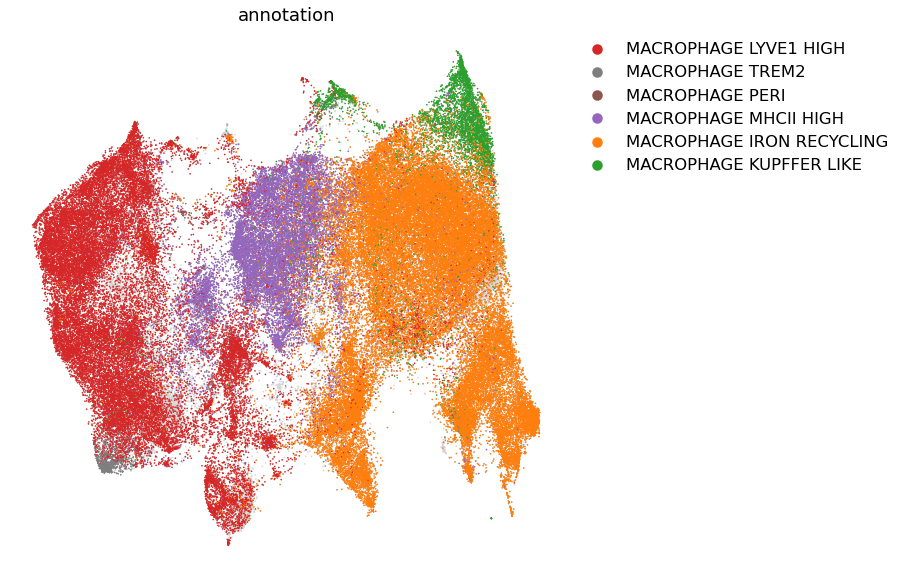

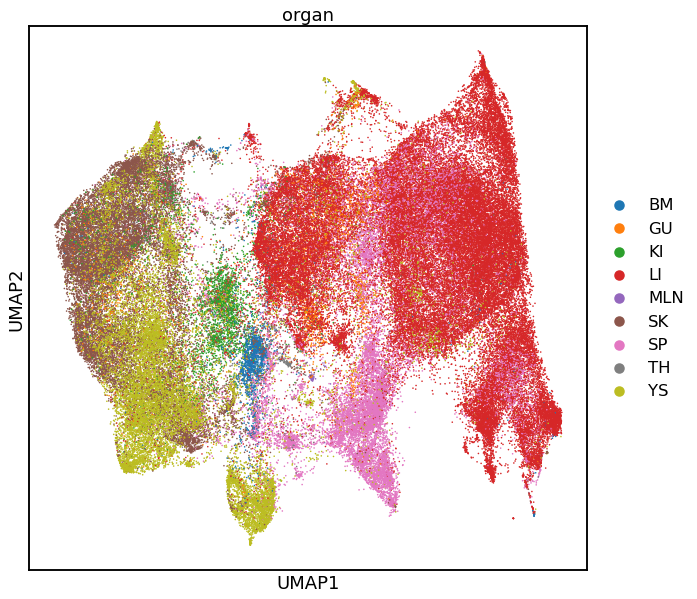

In [76]:
# sc.pl.umap(adata_mac_lognorm, color='anno_lvl_2_final_clean', show=False)
sns.set_context("talk")
plt.rcParams['figure.figsize'] = [10,10]
scv.pl.umap(adata_mac_lognorm, color=['anno_lvl_2_final_clean'], size=10, wspace=0.2,
           groups=[x for x in mac_annos_ordered if x not in ['MACROPHAGE_PROLIFERATING', 'MACROPHAGE_ERY']], 
           legend_loc='upper right',
           title='annotation', save='annotation.png')
sc.pl.umap(adata_mac_lognorm, color=['organ'], size=10, wspace=0.2)

saving figure to file /home/jovyan/mount/gdrive/Pan_fetal/Updates_and_presentations/revision/scvelo_proliferating.png


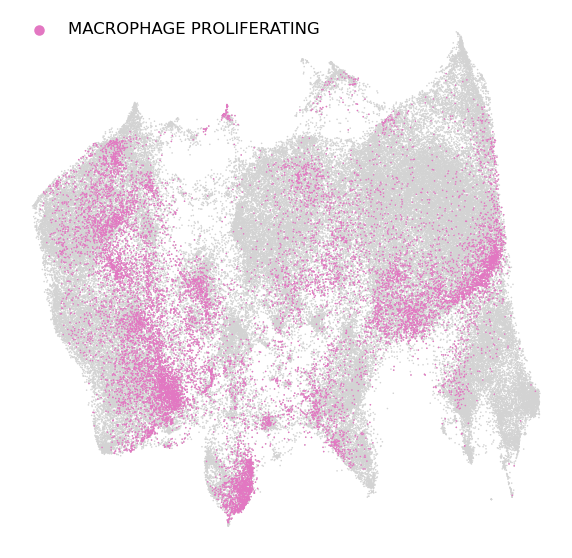

In [77]:
for g in ['MACROPHAGE_PROLIFERATING']:
    scv.pl.umap(adata_mac_lognorm, color=['anno_lvl_2_final_clean'], size=10, wspace=0.2,
                legend_loc='upper left',
               groups=[g], title='', save='proliferating.png')

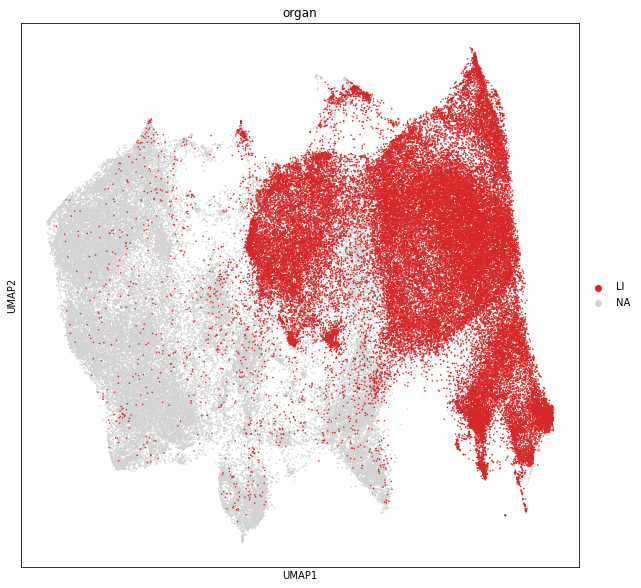

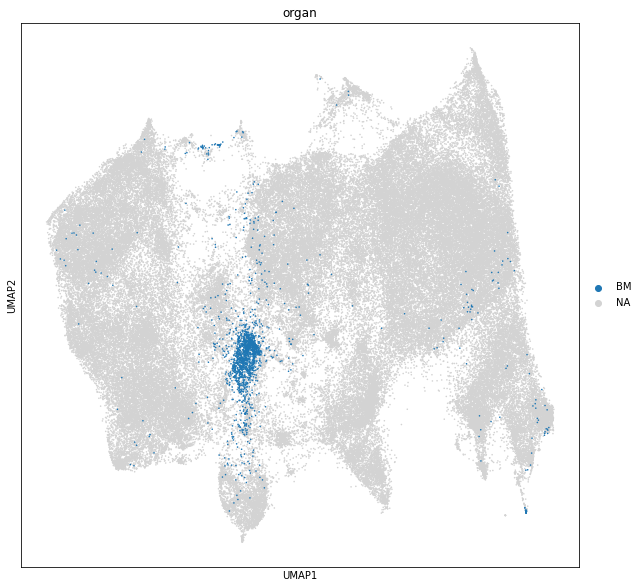

In [34]:
sc.pl.umap(adata_mac_lognorm, color=['organ'], size=10, wspace=0.2, groups=['LI'])
sc.pl.umap(adata_mac_lognorm, color=['organ'], size=10, wspace=0.2, groups=['BM'])

### Expression of markers

... storing 'anno_lvl_2_final_clean' as categorical
... storing 'annotation_lift' as categorical


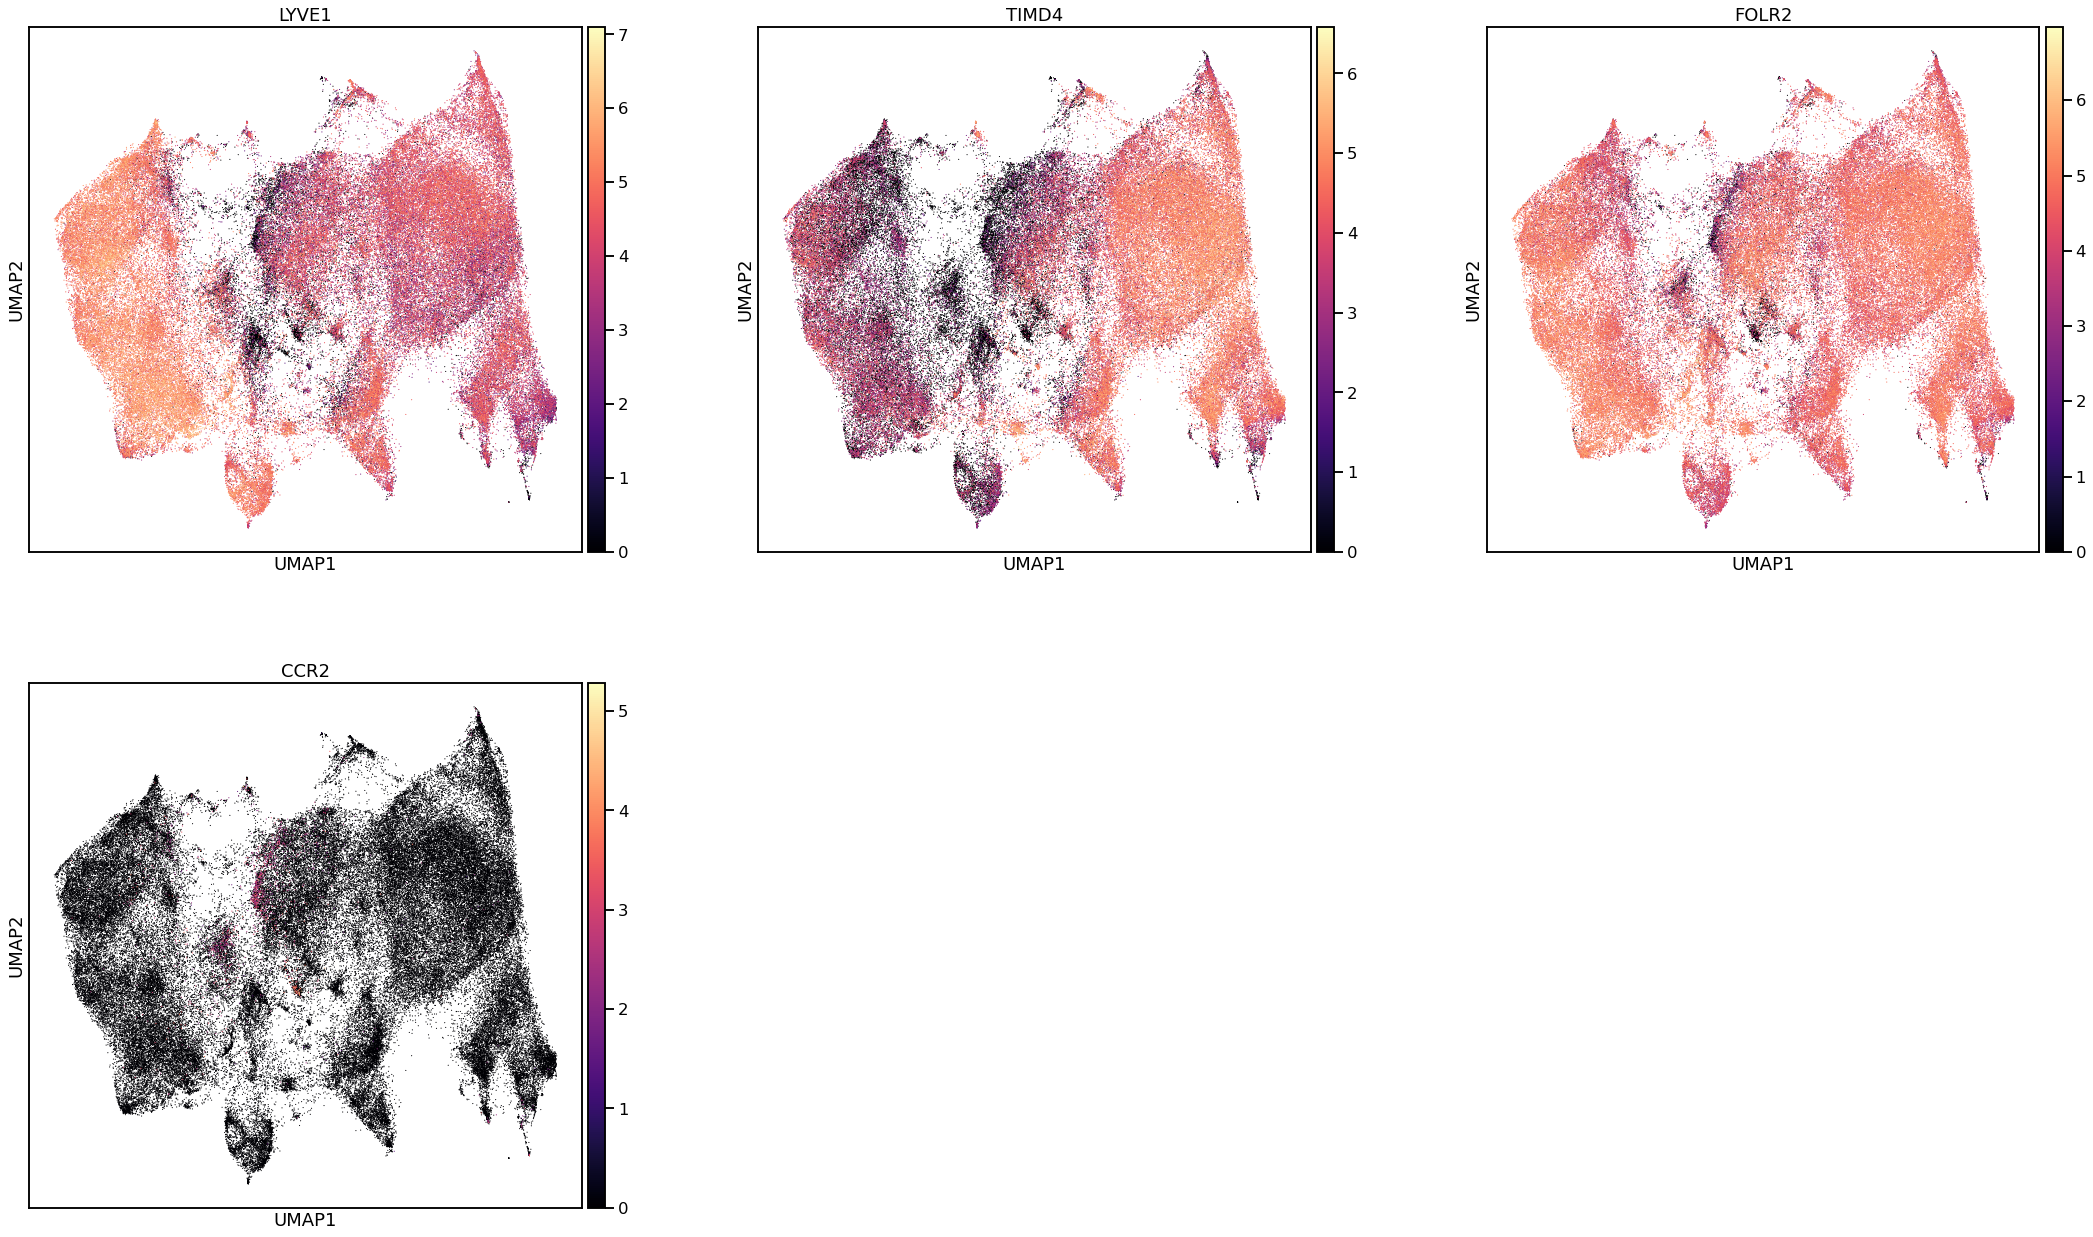

In [83]:
sns.set_context('talk')
sc.pl.umap(adata_mac_lognorm, color=['LYVE1', 'TIMD4',"FOLR2", 'CCR2'], size=5, wspace=0.2, groups=['BM'], cmap='magma', ncols=3)

In [253]:
pl_adata =adata_mac_lognorm[adata_mac_lognorm.obs['anno_lvl_2_final_clean'].isin([x for x in mac_annos_ordered if x not in ['MACROPHAGE_PROLIFERATING', 'MACROPHAGE_ERY']])].copy()
pl_adata.obs['groups'] = pl_adata.obs['anno_lvl_2_final_clean'].astype('str') + "_" + pl_adata.obs['organ'].astype('str')
pl_adata.obs['organ'] = pl_adata.obs['organ'].cat.reorder_categories(['YS', "LI", "BM", "TH", "SP", "MLN", "SK", "GU", "KI"])
pl_adata.obs['anno_lvl_2_final_clean'] = pl_adata.obs['anno_lvl_2_final_clean'].cat.reorder_categories(mac_annos_ordered)
pl_adata.obs['groups'] = pl_adata.obs['groups'].astype("category")
gr_order = pl_adata.obs[['groups', 'organ', 'anno_lvl_2_final_clean']].sort_values(['anno_lvl_2_final_clean',"organ"])['groups'].unique().tolist()
pl_adata.obs['groups'] = pl_adata.obs['groups'].cat.reorder_categories(gr_order)

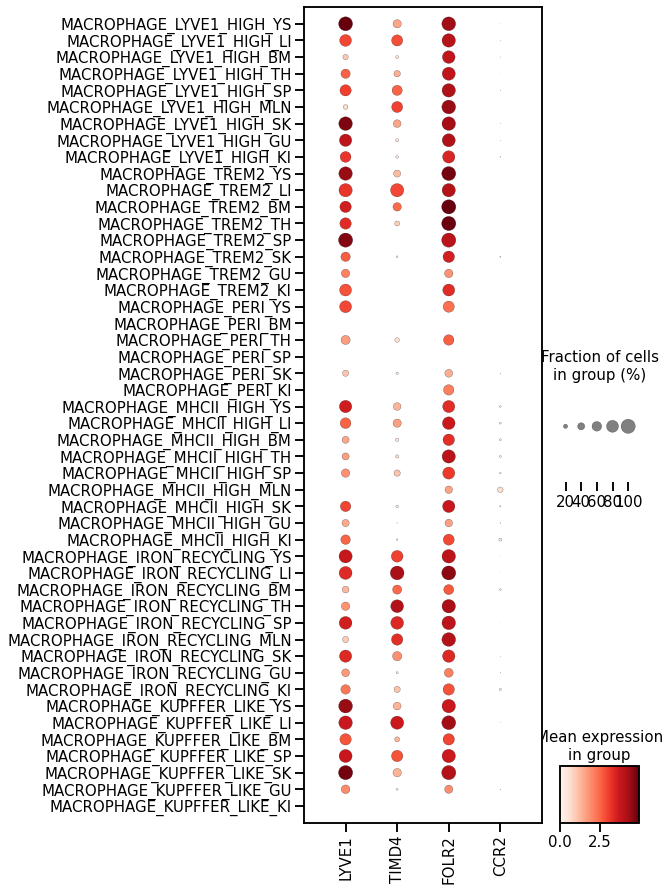

In [254]:
sc.pl.dotplot(pl_adata, ['LYVE1', 'TIMD4',"FOLR2", 'CCR2'], groupby='groups', figsize=(6,15))

In [13]:
mouse_mac_markers = {
    'TLPp':[
        'TIMD4',
        'LYVE1',
        'FOLR2',
        'NINJ1',
        'GAS6',
        'MRC1',
        'CD163',
        'IGF1',
        'SELENOP',
        'IGFBP4'
    ],
    'MHCII_high':[
        'CD14',
        'CST3',
        'LILRA5',
        'APOE',
        'TREM2',
        'H3F3B',
        'C5AR1',
        'ST3GAL6',
        'STAB1'
    ],
    'CCR2p':[
        'CCR2',
        'CD52',
        'HLA-DRB1', ## exact matching?
        'HLA-DRA', ##
        'S100A6',
        'BCL2A1',
        'S100A11',
        'CORO1A',
#         'CYP4F18', ## missing match in human
        'FXYD5'
    ]
}

In [19]:
import scanpy as sc
import pandas as pd
from matplotlib.pyplot import rc_context

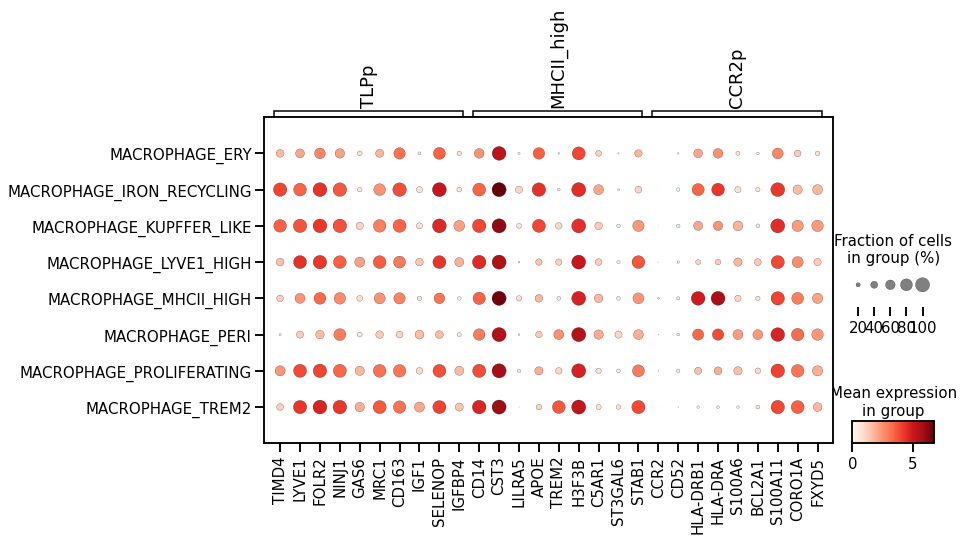

In [28]:
sns.set_context('talk')
sc.pl.dotplot(adata_mac_lognorm, mouse_mac_markers, groupby='anno_lvl_2_final_clean', figsize=(12,6), 
              dot_max=1, dot_min=0, save='EpelmanMarkers.png')

In [21]:
adata_mac_lognorm.layers['scaled'] = sc.pp.scale(adata_mac_lognorm, copy=True).X

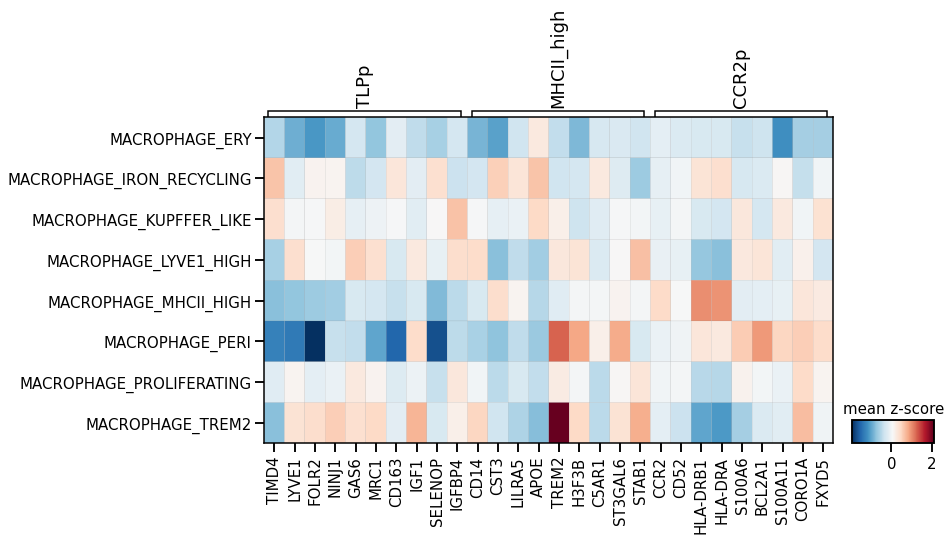

In [29]:
sc.pl.matrixplot(adata_mac_lognorm, mouse_mac_markers, groupby='anno_lvl_2_final_clean', figsize=(12,6), 
                 colorbar_title='mean z-score', layer='scaled',
                 cmap='RdBu_r', save='EpelmanMarkers_scaled.png')

In [127]:
def anndata2pseudobulk(adata, group_by, agg="s", min_ncells = 10):
    '''
    Params:
    ------
    adata: the anndata object
    group_by: list of obs columns to use for aggregation
    agg: "s" for sum (if adata.X are counts), "m" for mean (if adata.X are log-counts)
    min_ncells: minimum number of cells to keep pseudobulk sample (default=10)
    '''
    from scipy.sparse import csr_matrix
    import anndata
    if agg=="s" and "log1p" in adata.uns_keys():
        print("adata.X is in log-transformed, pseudobulking should be done on counts")
        return()
    ## Make obs for pseudobulk
    pseudobulk_obs = adata.obs[group_by].drop_duplicates()
    pseudobulk_obs = pseudobulk_obs[group_by].astype("str")
    pseudobulk_obs.index = pseudobulk_obs[group_by].agg("-".join, axis=1)
    ## Add column to obs assigning cells to pseudobulk samples
    adata.obs[group_by] = adata.obs[group_by].astype("str")
    adata.obs["pseudobulk_sample"] = adata.obs[group_by].agg("-".join, axis=1)
    ## Sum counts from same sample
    sample_dummies = pd.get_dummies(adata.obs["pseudobulk_sample"])[pseudobulk_obs.index].values
    sample_dummies = scipy.sparse.csr_matrix(sample_dummies)
    pseudobulk_X = adata.X.T.dot(sample_dummies)
    ## Check that pseudobulk profiles are the sum of all profiles in a sample
    a = np.array(adata[sample_dummies[:,0]!=0].X.sum(0)).flatten()
    b = pseudobulk_X[:,0].toarray().flatten()
    if not np.all(a == b):
        print("Error! Aggregation doesn't coincide with sum across the same sample")
        return()
    if agg=="m":
        pseudobulk_X = csr_matrix(pseudobulk_X / sample_dummies.toarray().sum(0))
    ## Sum number of zeros across samples
    X_expressed = adata.X.copy()
    X_expressed[X_expressed.nonzero()] = 1
    pseudobulk_frac_X = X_expressed.T.dot(sample_dummies)
    ## Make new anndata object
    pseudobulk_adata = anndata.AnnData(pseudobulk_X.T, obs=pseudobulk_obs, var=adata.var)
    pseudobulk_adata.layers['frac_expressed'] = pseudobulk_frac_X.T
    ## Add number of cells to obs 
    n_cells = adata.obs.groupby('pseudobulk_sample').count().iloc[:,0]
    n_cells.name = "n_cells"
    pseudobulk_adata.obs = pd.concat([pseudobulk_adata.obs, n_cells], axis=1)
    ## Filter obs by number of cells threshold
    pseudobulk_adata = pseudobulk_adata[pseudobulk_adata.obs['n_cells'] >= min_ncells]
    return(pseudobulk_adata)

In [274]:
import scipy
genes_oi = ['LYVE1', 'TIMD4',"FOLR2", 
            'CD14', 'CST3',
            'CCR2', 'CD52'
           ]
pbulk_adata = anndata2pseudobulk(pl_adata[:, genes_oi], group_by=['organ', 'anno_lvl_2_final_clean'], agg='m', min_ncells=3)

Trying to set attribute `.obs` of view, copying.


In [287]:
pbulk_adata = pbulk_adata.copy()
pbulk_adata

AnnData object with n_obs × n_vars = 43 × 7
    obs: 'organ', 'anno_lvl_2_final_clean', 'n_cells'
    var: 'GeneID', 'GeneName', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    layers: 'frac_expressed'

In [288]:
gex_df = pd.DataFrame(pbulk_adata.X.toarray(), columns=genes_oi)
gex_df.index = pbulk_adata.obs_names
n_expressed_df = pd.DataFrame(pbulk_adata.layers['frac_expressed'].toarray(), columns=['n_' + x for x in genes_oi])
n_expressed_df.index = pbulk_adata.obs_names
gex_df = pd.concat([pbulk_adata.obs, gex_df], 1)
gex_df = pd.concat([n_expressed_df, gex_df], 1)

In [289]:
%%R -i gex_df -i genes_oi
head(gex_df)

                             n_LYVE1 n_TIMD4 n_FOLR2 n_CD14 n_CST3 n_CCR2
SK-MACROPHAGE_MHCII_HIGH         307      49     381    394    458     18
SK-MACROPHAGE_LYVE1_HIGH       14625    6860   14540  14494  15351     96
SK-MACROPHAGE_PERI                25       7      34     57     75      1
SP-MACROPHAGE_IRON_RECYCLING   10249   10313   11156  10186  11796     16
SP-MACROPHAGE_LYVE1_HIGH        1322    1154    1666   1657   1790     16
YS-MACROPHAGE_LYVE1_HIGH       12617    6339   12412  12619  12838     34
                             n_CD52 organ    anno_lvl_2_final_clean n_cells
SK-MACROPHAGE_MHCII_HIGH         48    SK     MACROPHAGE_MHCII_HIGH     459
SK-MACROPHAGE_LYVE1_HIGH        605    SK     MACROPHAGE_LYVE1_HIGH   15426
SK-MACROPHAGE_PERI                8    SK           MACROPHAGE_PERI      75
SP-MACROPHAGE_IRON_RECYCLING   1109    SP MACROPHAGE_IRON_RECYCLING   11801
SP-MACROPHAGE_LYVE1_HIGH        388    SP     MACROPHAGE_LYVE1_HIGH    1794
YS-MACROPHAGE_LYVE1_HIGH  

In [313]:
%%R -i genes_oi

pl_df <- gex_df %>%
    pivot_longer(cols=unlist(genes_oi), names_to='gex_gene', values_to='gex') %>%
    pivot_longer(cols=paste0("n_",unlist(genes_oi)), names_to='n_gex_gene', values_to='n_gex') %>%
    mutate(n_gex_gene=str_remove(n_gex_gene, 'n_')) %>%
    filter(n_gex_gene == gex_gene) %>%
    mutate(organ=factor(organ, levels=c("YS", "LI", "BM", "TH", "SP", "MLN", "SK", "GU", "KI"))) %>%
    mutate(anno_lvl_2_final_clean=factor(str_replace(str_remove(anno_lvl_2_final_clean, 'MACROPHAGE_'), '_', " "), 
                                  levels=rev(str_replace(str_remove(mac_annos_ordered, 'MACROPHAGE_'), '_', " ")))) %>%

    mutate(gex_gene=factor(gex_gene, levels=genes_oi)) 


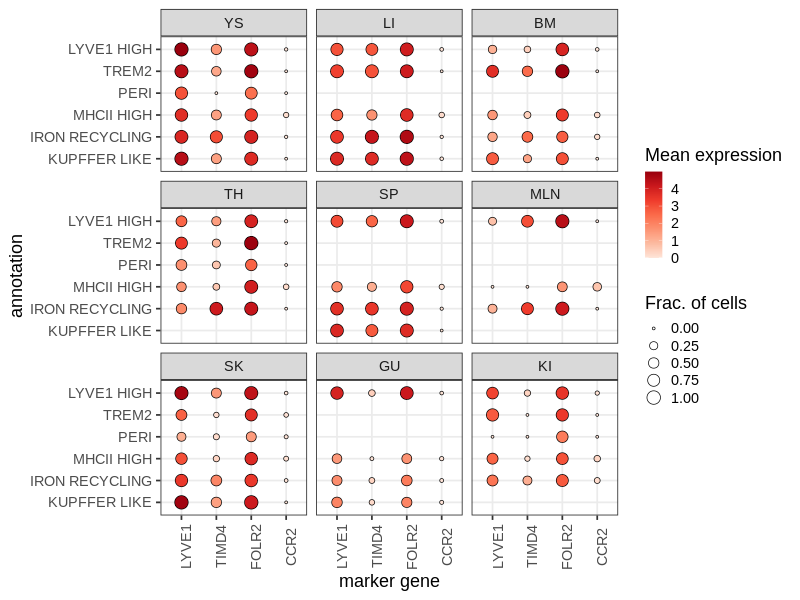

In [320]:
%%R -w 800 -h 600
pl_df %>%
#     group_by(gex_gene) %>%
#     mutate(gex=(gex - min(gex))/(max(gex) - min(gex))) %>%
#     filter(gex_gene=='LYVE1') %>%
    filter(gex_gene %in% c('LYVE1', "TIMD4", "CCR2", 'FOLR2')) %>%
    ggplot(aes( gex_gene, anno_lvl_2_final_clean, fill=gex, size=n_gex/n_cells)) +
    geom_point(shape=21) +
    scale_fill_distiller(palette='Reds', direction=1, name='Mean expression') +
    facet_wrap(organ~.) +
    theme_bw(base_size=18) +
    scale_size(name='Frac. of cells') +
    theme(axis.text.x=element_text(angle=90)) +
    xlab("marker gene") + ylab('annotation') +
    ggsave(paste0(figdir, 'Epelman_markers_macs_dotplor.png'), height=8, width=8)

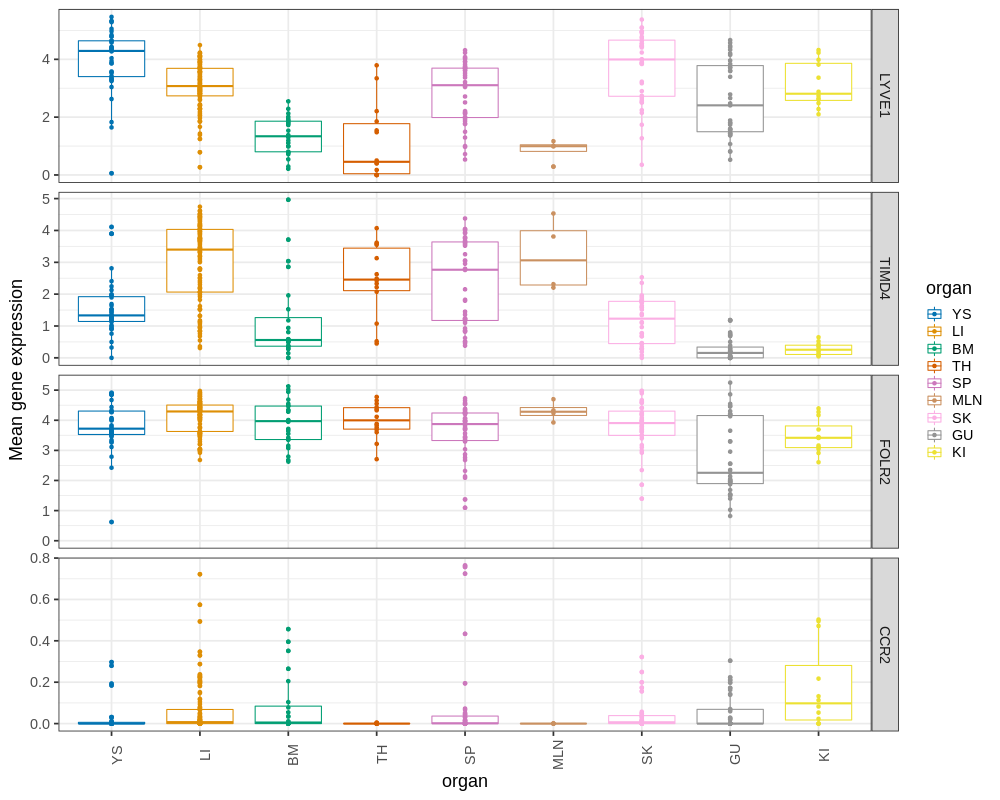

In [252]:
%%R -w 1000 -h 800 
pl_df %>%
    filter(gex_gene %in% c('LYVE1', "TIMD4", "CCR2", 'FOLR2')) %>%
    ggplot(aes(organ, gex, color=organ)) +
    geom_boxplot() +
    geom_point(aes(color=organ)) +
    scale_fill_distiller(palette='RdBu') +
    scale_y_continuous(limits = function(x){c(0, max(0.1, x))}) +
    facet_grid(gex_gene ~ ., scales='free', space='free_x') +
    theme_bw(base_size=18) +
    scale_color_manual(values=org_colors) +
    theme(axis.text.x=element_text(angle=90), strip.text.x=element_text(angle=90)) +
    ylab('Mean gene expression') +
    ggsave(paste0(figdir, 'Epelman_markers_macs.png'), height=10, width=10)
    

### New clustering and distribution of proliferating cells

In [101]:
sc.tl.leiden(adata_mac_lognorm, resolution=1.5, key_added='leiden_150', n_iterations=5, neighbors_key="scvi")
sc.tl.leiden(adata_mac_lognorm, resolution=1, key_added='leiden_100', n_iterations=5, neighbors_key="scvi")

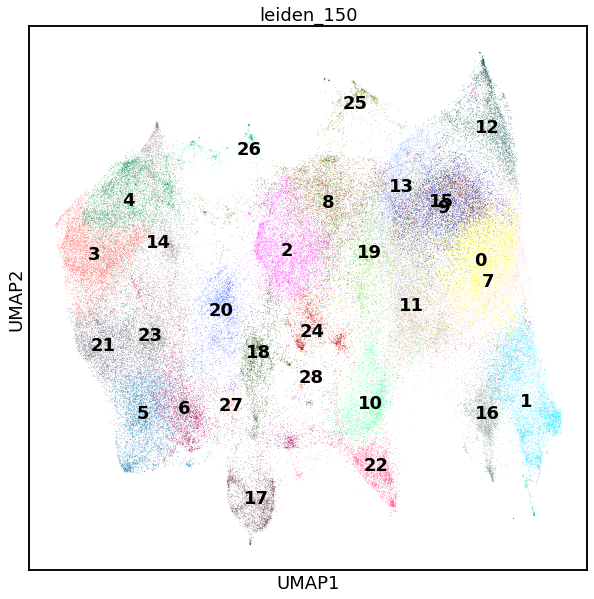

In [115]:
sc.pl.umap(adata_mac_lognorm, color='leiden_150', legend_loc='on data')

In [116]:
conf_mat = sc.metrics.confusion_matrix(data=adata_mac_lognorm.obs, new='leiden_150', orig='anno_lvl_2_final_clean')
conf_mat = conf_mat.loc[[x for x in conf_mat.index if x!='MACROPHAGE_PROLIFERATING']] 

In [121]:
lift_anno = conf_mat.idxmax(0).reset_index()
lift_anno.columns = ['leiden_150', 'annotation_lift']
if 'annotation_lift' in adata_mac_lognorm.obs.columns: 
    adata_mac_lognorm.obs = adata_mac_lognorm.obs.drop('annotation_lift', 1)
adata_mac_lognorm.obs = pd.merge(adata_mac_lognorm.obs, lift_anno, how='left')

/opt/conda/envs/ed6/lib/python3.8/site-packages/anndata/_core/anndata.py:794: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


saving figure to file /home/jovyan/mount/gdrive/Pan_fetal/Updates_and_presentations/revision/scvelo_macs_embedding.png


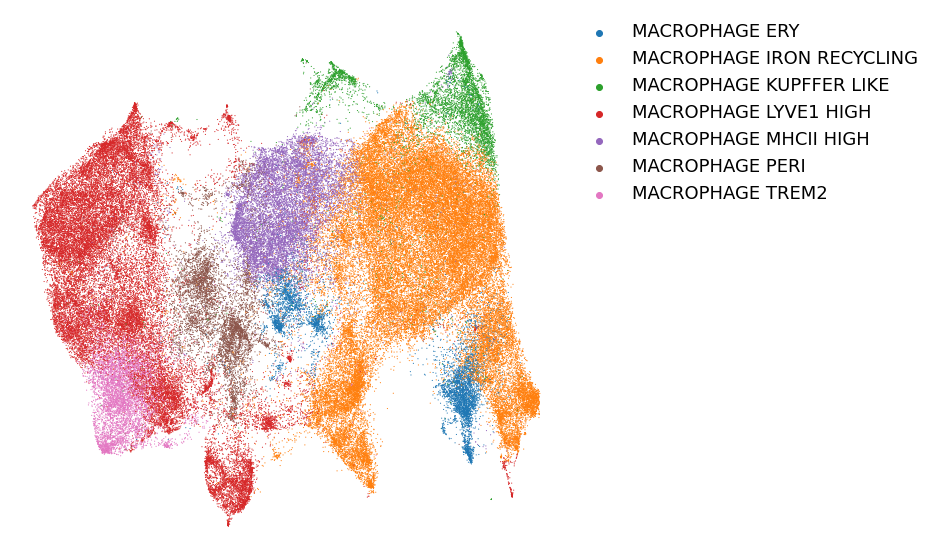

In [84]:
plt.rcParams['figure.figsize'] = [10,10]
scv.pl.umap(adata_mac_lognorm, color='annotation_lift', legend_loc='upper right', size=5, legend_fontsize=18, title='', save='macs_embedding.png')

saving figure to file /home/jovyan/mount/gdrive/Pan_fetal/Updates_and_presentations/revision/scvelo_macs_embedding_prolif.png


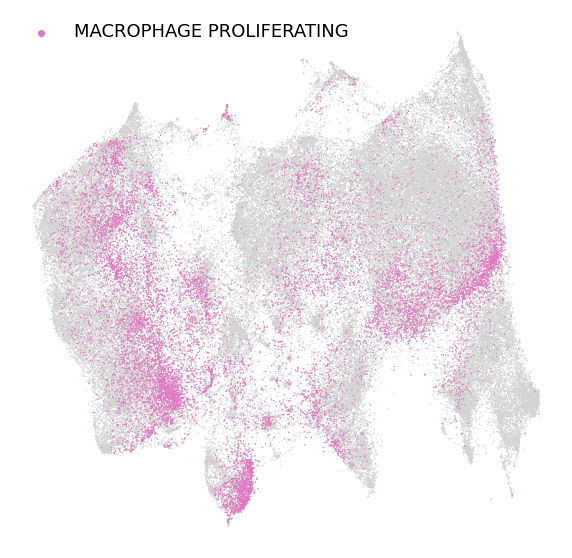

In [86]:
plt.rcParams['figure.figsize'] = [10,10]
scv.pl.umap(adata_mac_lognorm, color='anno_lvl_2_final_clean', legend_loc='upper left', 
            groups='MACROPHAGE_PROLIFERATING',
            size=7, legend_fontsize=18, title='', save='macs_embedding_prolif.png')

In [2]:
adata_mac_lognorm = sc.read_h5ad('/nfs/team205/ed6/data/Fetal_immune/macs.h5ad')

In [29]:
def frac_proliferating(mac_obs):
    mac_obs.anno_lvl_2_final_clean = mac_obs.anno_lvl_2_final_clean.astype('str')
    mac_obs.annotation_lift = mac_obs.annotation_lift.astype('str')
    conf_mat = sc.metrics.confusion_matrix(data=mac_obs, new='annotation_lift', orig='anno_lvl_2_final_clean', normalize=False)
    conf_mat = conf_mat/conf_mat.sum(0)
    if 'MACROPHAGE_PROLIFERATING' not in conf_mat.index:
        conf_mat.loc['MACROPHAGE_PROLIFERATING',:] = 0
    prolif_df = conf_mat.loc['MACROPHAGE_PROLIFERATING']
    prolif_df = prolif_df.loc[[x for x in mac_annos_ordered if x in prolif_df.index]]
    return(prolif_df)

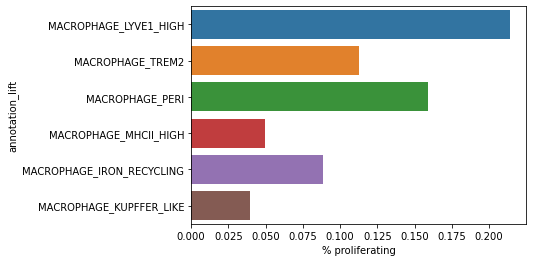

In [10]:
## Full dataset
prolif_df = frac_proliferating(adata_mac_lognorm.obs)
sns.barplot(data=prolif_df.reset_index(), y='annotation_lift', x='MACROPHAGE_PROLIFERATING');
plt.xlabel("% proliferating");

In [33]:
adata_mac_lognorm.obs['group'] = adata_mac_lognorm.obs['donor'].astype('str') + "_" + adata_mac_lognorm.obs['organ'].astype('str')

In [34]:
prolif_df_all = pd.DataFrame()
for i,o in enumerate(adata_mac_lognorm.obs['group'].unique().tolist()):
    mac_obs = adata_mac_lognorm.obs[adata_mac_lognorm.obs['group'] == o].copy()
    prolif_df_org = frac_proliferating(mac_obs)
    prolif_df_org = prolif_df_org.reset_index()
    prolif_df_org['organ'] = o
    n_cells = mac_obs.groupby('annotation_lift').size().reset_index()
    n_cells.columns = ['annotation_lift', 'n_cells']
    prolif_df_org = pd.merge(prolif_df_org, n_cells, how='left')
    prolif_df_all = pd.concat([prolif_df_all, prolif_df_org], 0)

In [35]:
prolif_df_all['group'] = prolif_df_all['organ'].copy()
prolif_df_all['organ'] = [x[1] for x in prolif_df_all['group'].str.split("_")]

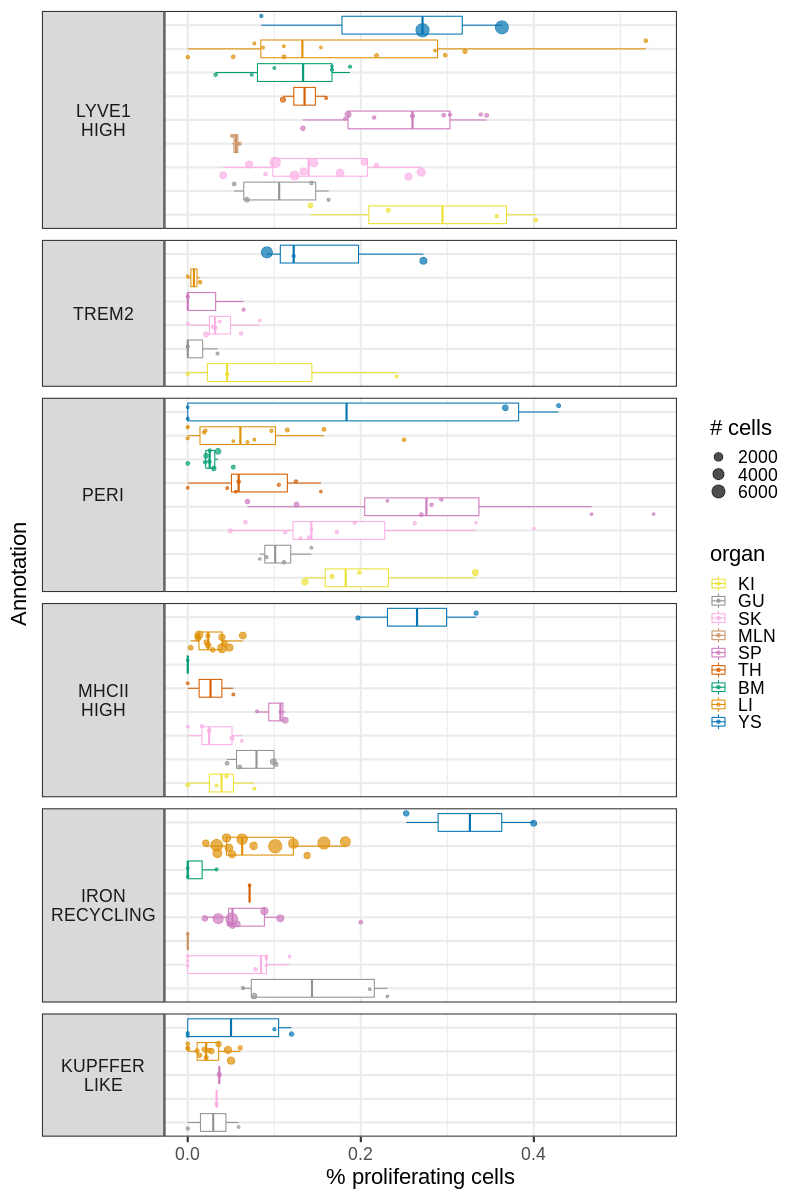

In [74]:
%%R -i prolif_df_all -w 800 -h 1200 -i mac_annos_ordered -i figdir
org_colors <- read.csv("../../metadata/organ_colors.csv")
org_colors <- setNames(org_colors$color, org_colors$organ)

fix_mac_names <- function(name){
    name %>% str_remove("MACROPHAGE_") %>% str_replace("_", "\n")
}

prolif_df_all %>%
    filter(n_cells > 10) %>%
#     mutate(annotation_lift = str_remove(annotation_lift, levels=(unlist(mac_annos_ordered)))) %>%
    mutate(annotation_lift = factor(fix_mac_names(annotation_lift), levels=fix_mac_names(unlist(mac_annos_ordered)))) %>%
    mutate(organ = factor(organ, levels=rev(names(org_colors)))) %>%
    ggplot(aes(organ, MACROPHAGE_PROLIFERATING, color=organ)) +
    geom_boxplot(outlier.alpha=0) +
    geom_point(aes(color=organ, size=n_cells), position=position_jitter(), alpha=0.7) +
    coord_flip() +
    theme_bw(base_size=22) +
    scale_color_manual(values=org_colors) +
    facet_grid(annotation_lift~., switch="both", scales='free', space='free') +
    scale_size(name='# cells') +
    xlab("Annotation") + ylab("% proliferating cells") +
    theme(axis.text.y=element_blank(), axis.ticks.y=element_blank(),
          strip.text.y.left=element_text(angle=0)
         ) +
    ggsave(paste0(figdir,'macs_percent_proliferating.pdf'), width=8, height=12)


### Trajectory analysis

In [ ]:
sc.tl.diffmap(adata_mac_lognorm, neighbors_key='scvi')

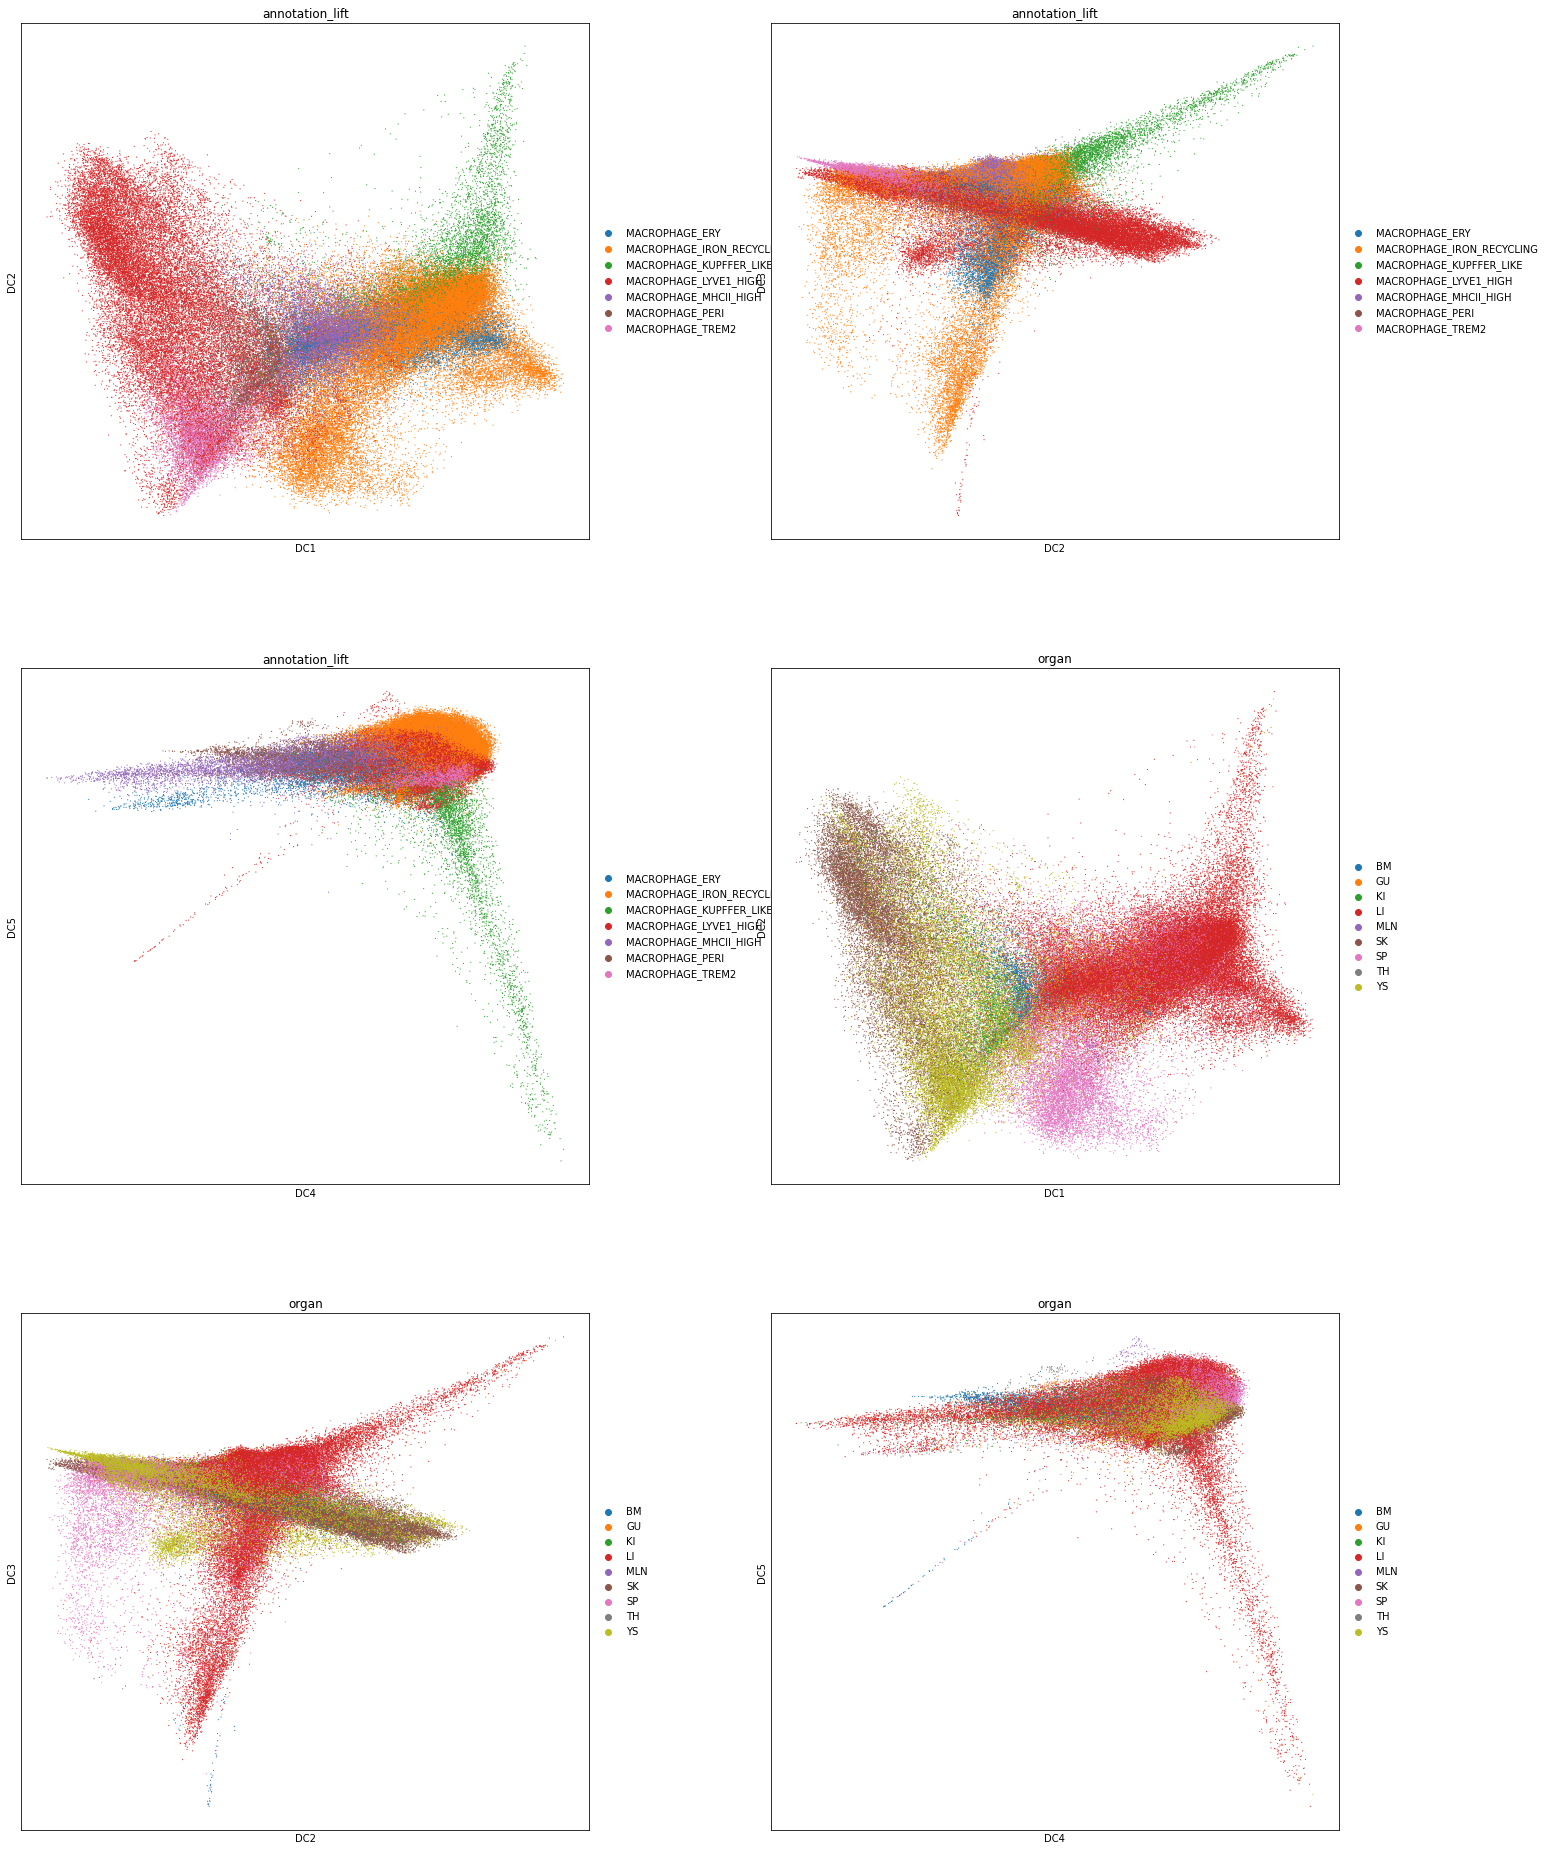

In [20]:
plt.rcParams['figure.figsize'] = [10,10]
sc.pl.diffmap(adata_mac_lognorm, size=5, color=['annotation_lift', 'organ'], components=['1,2', '2,3', '4,5'], ncols=2, wspace=0.2)

In [21]:
root_cell_index = adata_mac_lognorm.obsm['X_diffmap'][:,1].argmin()
adata_mac_lognorm.uns['iroot'] = root_cell_index

In [44]:
sc.tl.dpt(adata_mac_lognorm, n_dcs=3, neighbors_key='scvi')

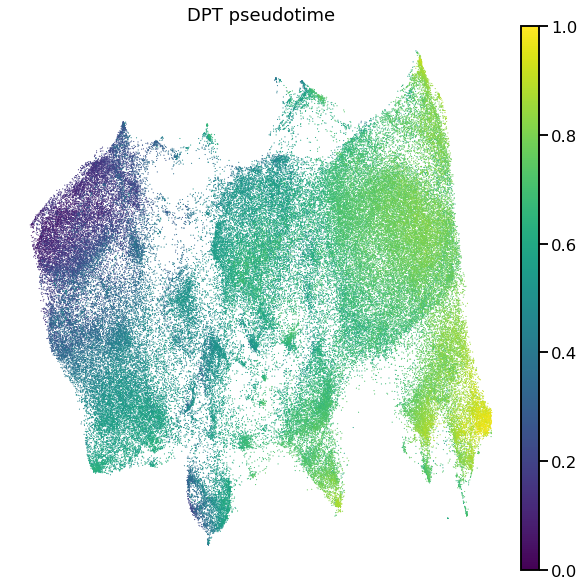

In [67]:
sns.set_context('talk')
sc.pl.umap(adata_mac_lognorm, size=5, color=['dpt_pseudotime'], components=['1,2'], ncols=1, title='DPT pseudotime', frameon=False,
          save='pseudotime.png')

In [48]:
df = adata_mac_lognorm.obs[['dpt_pseudotime', 'annotation_lift', 'organ', 'age']]

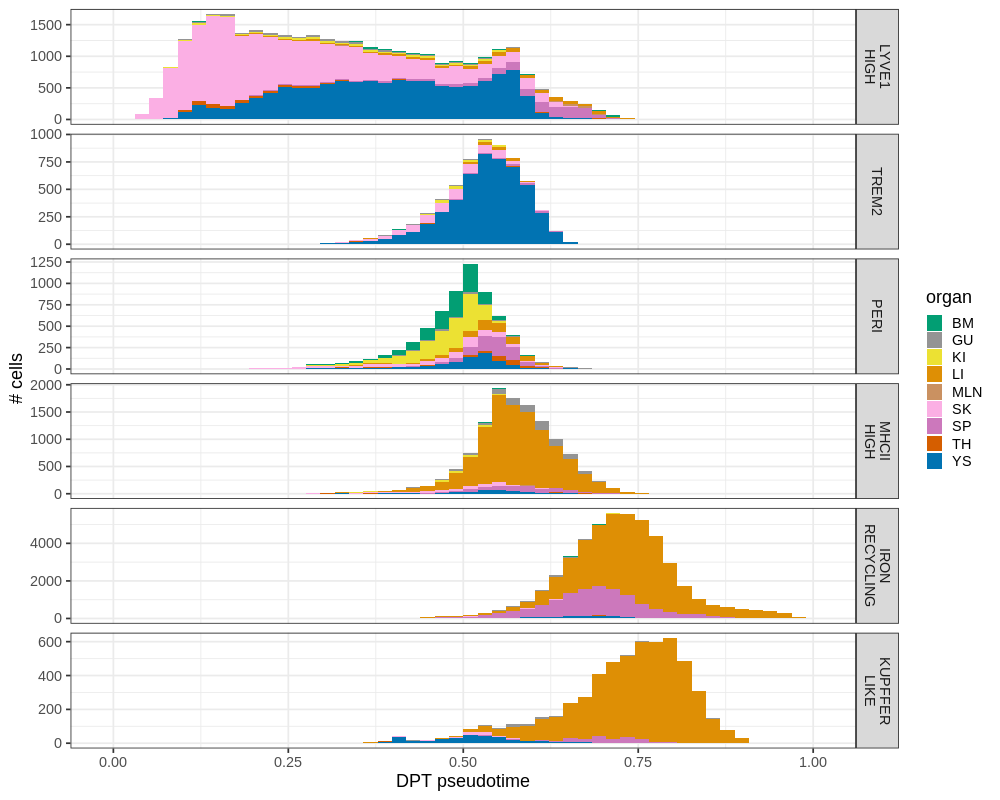

In [65]:
%%R -i df -w 1000 -h 800 -i mac_annos_ordered -i figdir
org_colors <- read.csv("../../metadata/organ_colors.csv")
org_colors <- setNames(org_colors$color, org_colors$organ)

df %>%
    mutate(annotation_lift=factor(str_replace(str_remove(annotation_lift, 'MACROPHAGE_'), '_', "\n"), 
                                  levels=str_replace(str_remove(mac_annos_ordered, 'MACROPHAGE_'), '_', "\n"))) %>%
    filter(!is.na(annotation_lift)) %>%
    ggplot(aes(dpt_pseudotime, fill=organ)) +
    scale_fill_manual(values=org_colors) +
    geom_histogram(bins=50) +
    theme_bw(base_size=18) +
    facet_grid(annotation_lift~., scales='free_y') +
    ylab("# cells") +
    xlab("DPT pseudotime") +
    ggsave(paste0(figdir, "macs_ordering_histogram.png"), width=8, height=8)

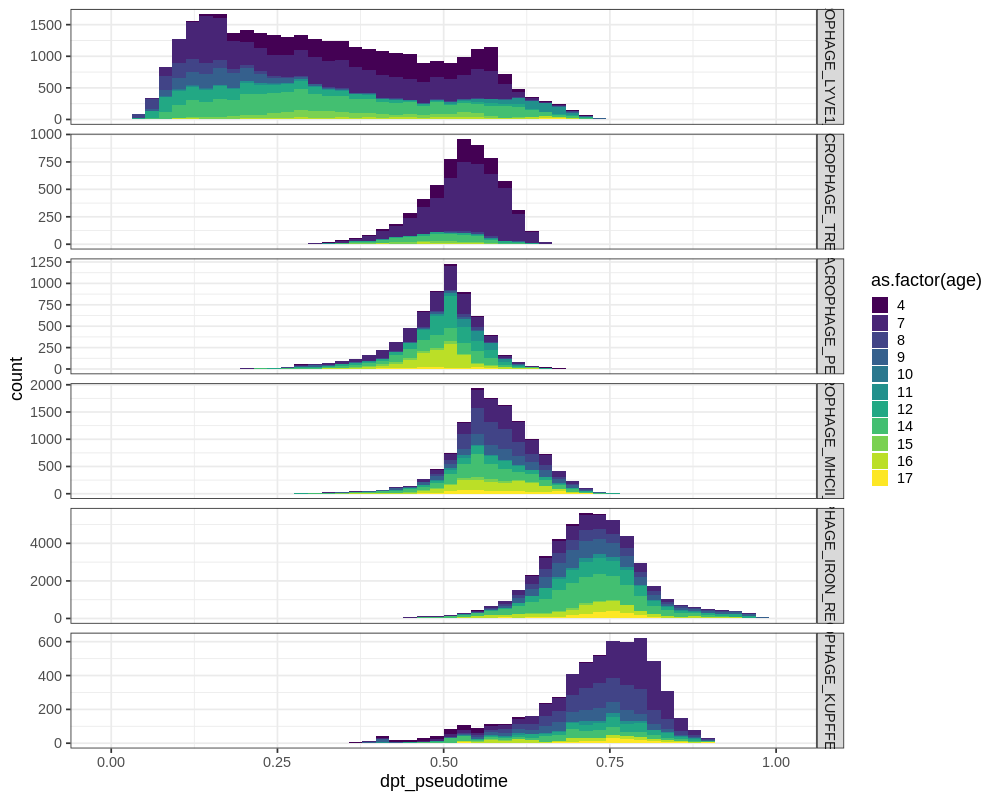

In [54]:
%%R  -w 1000 -h 800 -i mac_annos_ordered
org_colors <- read.csv("../../metadata/organ_colors.csv")
org_colors <- setNames(org_colors$color, org_colors$organ)

df %>%
    mutate(annotation_lift=factor(annotation_lift, levels=mac_annos_ordered)) %>%
    filter(!is.na(annotation_lift)) %>%
    ggplot(aes(dpt_pseudotime, fill=as.factor(age))) +
    scale_fill_viridis_d() +
    geom_histogram(bins=50) +
    theme_bw(base_size=18) +
    facet_grid(annotation_lift~., scales='free_y')